<a href="https://colab.research.google.com/github/saislam10/DeepLearningAssessment6/blob/main/Copy_of_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [32]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping


## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [33]:
poe_url = "https://www.gutenberg.org/files/2147/2147-0.txt"
lovecraft_url = "https://www.gutenberg.org/files/40637/40637-0.txt"

poe_text = requests.get(poe_url).text
lovecraft_text = requests.get(lovecraft_url).text

In [34]:
# Clean the texts
def clean_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()
    return text

poe_text = clean_text(poe_text)
lovecraft_text = clean_text(lovecraft_text)

# Combine the texts and tokenize the characters
texts = [poe_text, lovecraft_text]
labels = [0, 1]  # 0 for Poe, 1 for Lovecraft

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
alphabet_length = len(tokenizer.word_index)

sequences = tokenizer.texts_to_sequences(texts)

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

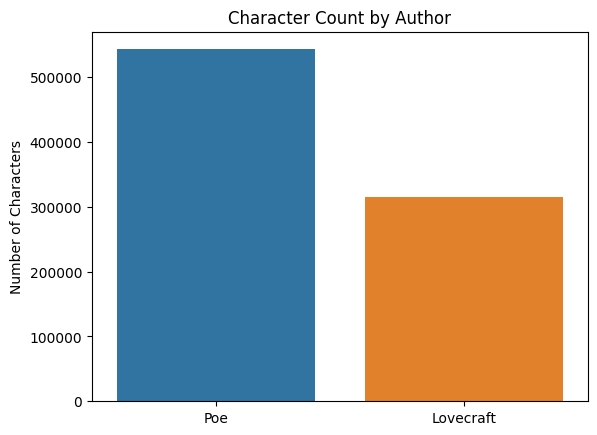

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of characters for each author
num_chars_poe = len(poe_text)
num_chars_lovecraft = len(lovecraft_text)

# Display the counts on a Seaborn countplot
authors = ['Poe', 'Lovecraft']
char_counts = [num_chars_poe, num_chars_lovecraft]

sns.barplot(x=authors, y=char_counts)
plt.ylabel('Number of Characters')
plt.title('Character Count by Author')
plt.show()


## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [36]:
# Sliding window function
def sliding_window(text, label, sequence_length):
    num_sequences = len(text) - sequence_length + 1
    X = np.zeros((num_sequences, sequence_length))
    y = np.zeros((num_sequences, 1))

    for i in range(num_sequences):
        X[i, :] = text[i:i + sequence_length]
        y[i] = label

    return X, y

# Generate sequences and labels for both authors using the sliding window
sequence_length = 60

X_poe, y_poe = sliding_window(sequences[0], labels[0], sequence_length)
X_lovecraft, y_lovecraft = sliding_window(sequences[1], labels[1], sequence_length)

X = np.concatenate([X_poe, X_lovecraft], axis=0)
y = np.concatenate([y_poe, y_lovecraft], axis=0)


## Data splitting
Split the data into train, validate and test sets. Make 

In [37]:
# Split the tokenized data into train, validation, and test sets
X_tokenized_train, X_tokenized_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_tokenized_val, X_tokenized_test, y_val, y_test = train_test_split(X_tokenized_temp, y_temp, test_size=0.5, random_state=42)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [38]:
# Define the LSTM model with the Embedding layer
def build_lstm_model(sequence_length, alphabet_length):
    model = Sequential()
    model.add(Embedding(alphabet_length + 1, 32, input_length=sequence_length))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_lstm_model(sequence_length, alphabet_length)


## Model training
Train the model and apply early stopping.

In [41]:
# Compile the model with the correct loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and apply early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_tokenized_train, y_train,
                    validation_data=(X_tokenized_val, y_val),
                    epochs=10, batch_size=512,
                    callbacks=[early_stopping])


Epoch 1/10
1175/1175 [==============================] - 635s 536ms/step - loss: 0.1092 - accuracy: 0.9643 - val_loss: 0.0854 - val_accuracy: 0.9705
Epoch 2/10
1175/1175 [==============================] - 601s 512ms/step - loss: 0.0729 - accuracy: 0.9734 - val_loss: 0.0655 - val_accuracy: 0.9762
Epoch 3/10
1175/1175 [==============================] - 610s 519ms/step - loss: 0.0632 - accuracy: 0.9753 - val_loss: 0.0590 - val_accuracy: 0.9762
Epoch 4/10
1175/1175 [==============================] - 614s 523ms/step - loss: 0.0583 - accuracy: 0.9759 - val_loss: 0.0517 - val_accuracy: 0.9767
Epoch 5/10
1175/1175 [==============================] - 611s 520ms/step - loss: 0.0524 - accuracy: 0.9765 - val_loss: 0.0457 - val_accuracy: 0.9774
Epoch 6/10
1175/1175 [==============================] - 614s 523ms/step - loss: 0.0475 - accuracy: 0.9770 - val_loss: 0.0415 - val_accuracy: 0.9777
Epoch 7/10
1175/1175 [==============================] - 609s 518ms/step - loss: 0.0436 - accuracy: 0.9773 - val_

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [43]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_tokenized_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

4027/4027 [==============================] - 81s 20ms/step - loss: 0.0316 - accuracy: 0.9787
Test loss: 0.0316, Test accuracy: 0.9787


## Confusion matrix
Calculate and display the confusion matrix.

4027/4027 [==============================] - 64s 16ms/step


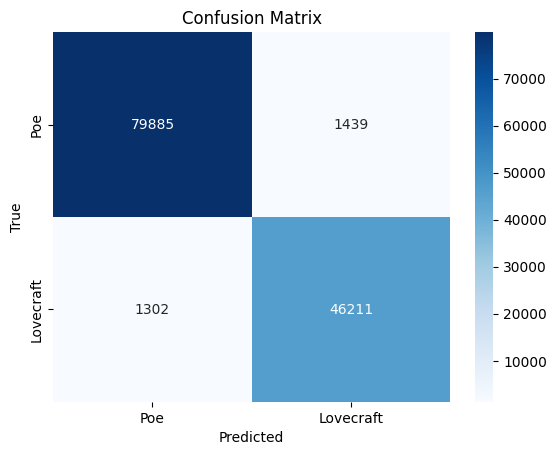

In [45]:
from sklearn.metrics import confusion_matrix

# Predict labels for the test data
y_pred_proba = model.predict(X_tokenized_test)
y_pred = np.round(y_pred_proba).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=authors, yticklabels=authors)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [46]:
summary = (f"We trained a deep learning model to classify text from two authors, Edgar Allan Poe and H.P. Lovecraft, "
           f"based on input sequences of 60 characters. After downloading and preprocessing the text from each author, "
           f"we tokenized the characters and generated sequences using a sliding window approach. We built and trained "
           f"an LSTM model with an embedding layer on the tokenized sequences and applied early stopping during training "
           f"to prevent overfitting. We evaluated the model's performance on a test dataset and obtained a test loss "
           f"of {loss:.4f} and a test accuracy of {accuracy:.4f}. A confusion matrix was displayed to visualize the "
           f"classification results.")
print(summary)


We trained a deep learning model to classify text from two authors, Edgar Allan Poe and H.P. Lovecraft, based on input sequences of 60 characters. After downloading and preprocessing the text from each author, we tokenized the characters and generated sequences using a sliding window approach. We built and trained an LSTM model with an embedding layer on the tokenized sequences and applied early stopping during training to prevent overfitting. We evaluated the model's performance on a test dataset and obtained a test loss of 0.0316 and a test accuracy of 0.9787. A confusion matrix was displayed to visualize the classification results.
